In [ ]:
!pip install pytorch pytorch-cuda=11.7 -c pytorch -c nvidia
!pip install neuralforecast==1.5.0

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'


In [660]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
from sklearn.metrics import mean_absolute_percentage_error
#from sklearn.metrics import root_mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from neuralforecast import NeuralForecast
import neuralforecast
from neuralforecast.models import NBEATS, NHITS, TFT
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch
from typing import Union

In [661]:
neuralforecast.__version__

'1.5.0'

In [662]:
print(torch.cuda.is_available())

False


In [663]:
class WMAPE(torch.nn.Module):

    def __init__(self):
        super(WMAPE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = [""]
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return y_hat.squeeze(-1)

    def __call__(
        self,
        y: torch.Tensor,
        y_hat: torch.Tensor,
        mask: Union[torch.Tensor, None] = None,
    ):
        if mask is None:
            mask = torch.ones_like(y_hat)

        num = mask * (y - y_hat).abs()
        den = mask * y.abs()
        return num.sum() / den.sum()
    
def mape(true_values, predicted):
    return np.mean(np.abs((true_values - predicted) / true_values))

def wmape_(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

def rmse_(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_pred, y_true):
    """
    Compute the Root Mean Squared Log Error for hypthesis y_pred and targets y_true
    Args:
        y_pred - numpy array containing predictions with shape (n_samples, n_targets)
        y_true - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean())

#r2_score(y_true, y_pred)
#calcula a semana do mes
def calc_week(day):
  if day>=1 and day<=7:
    return 0
  if day>=8 and day<=14:
    return 1
  if day>=15 and day<=21:
    return 2
  if day>=22 and day<=28:
    return 3
  else:
    return 4

def add_time_features(UC):
    #cria time features
    min_year=min(UC.ds.dt.year.values)
    UC['year'] = (UC.ds.apply(lambda x: x.year)-min_year).astype(int)
    UC['quarter'] = UC.ds.apply(lambda x: x.quarter-1).astype(int)
    UC['month'] = UC.ds.apply(lambda x: x.month-1).astype(int)
    UC['day_of_month'] = UC.ds.apply(lambda x: x.day-1).astype(int)
    UC['day_of_year'] = UC.ds.apply(lambda x: x.dayofyear-1).astype(int)
    UC['day_of_week'] = UC.ds.dt.weekday.astype(int) #
    UC['week_of_month'] = UC.ds.apply(lambda x:calc_week(x.day)).astype(int)
    UC['week_of_year'] = UC.ds.apply(lambda x: x.weekofyear-1).astype(int)
    UC['is_weekeend'] = UC.ds.apply( lambda x : 1 if x.day_of_week in [5,6] else 0 ).astype(int)
    is_weekeend = pd.get_dummies(UC['is_weekeend'])
    is_weekeend.columns = ['is_weekeend_0','is_weekeend_1']
    UC.drop('is_weekeend',axis=1,inplace=True)
    UC = pd.concat([UC, is_weekeend], axis=1)
    return UC

def target_encoding(data,feautre,
                    target="y",
                    agg_functions={"mean","median","std"}):#,"min",lambda x: x.quantile(0.25),"median",lambda x: x.quantile(0.75),"max"}):
    agg=data.groupby(feautre)[target].agg(agg_functions)
    agg.columns=[column+"_per_y" for column in agg.columns.tolist()]
    return agg

def add_target_encoding_features(train, valid, time_feautres,target='y'):
    agg=target_encoding(train,time_feautres,target='y')
    agg.index.names=time_feautres
    agg.reset_index(inplace=True, level = time_feautres)
    train=train.merge(agg,how="left",on=time_feautres)
    valid=valid.merge(agg,how="left",on=time_feautres)
    return train, valid

    
def fill_na(data):
    for colum in data.columns:
        if data[colum].dtype in ['float64','float32','int64','int32']:
            data[colum].interpolate(method='linear', axis=0, limit_direction='both', inplace=True)
    #data.sort_index(inplace=True)
    return data

# scale train and test data to [-1, 1]
def scale(train,columns_scale,target=['y']):
    train2=train.copy()
    # fit scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    # scaler = scaler.fit(train)
    # transform train
    #train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.fit_transform(train[columns_scale])
    train2[columns_scale]=train_scaled
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaled = scaler.fit_transform(train[target])
    train2[target]=target_scaled
    
    # transform test
    return scaler, train2


# inverse scaling for a forecasted value
def invert_scale(scaler,train,columns_scale):
    train2=train.copy()
    array = np.array(train[columns_scale].values)
    #array = array.reshape(len(array), 1)
    inverted = scaler.inverse_transform(array)
    #inverted = inverted.reshape(len(inverted))
    train2[columns_scale]=inverted
    return train2

## Carrega os Dados e Análise Exploratória:

In [664]:
data = pd.read_csv('data_set/train.csv', index_col='id', parse_dates=['date'])
data2 = data.loc[((data['store_nbr'] == 1) & (data['family'].isin(['MEATS', 'PERSONAL CARE']))) | ((data['store_nbr'] == 2) & (data['family'].isin(['AUTOMOTIVE', 'BEAUTY']))), ['date', 'store_nbr', 'family', 'sales', 'onpromotion']]

In [665]:
data2

,date,store_nbr,family,sales,onpromotion
id,,,,,
24,2013-01-01,1,MEATS,0.000,0
25,2013-01-01,1,PERSONAL CARE,0.000,0
363,2013-01-01,2,AUTOMOTIVE,0.000,0
365,2013-01-01,2,BEAUTY,0.000,0
1806,2013-01-02,1,MEATS,369.101,0
...,...,...,...,...,...
2997689,2017-08-14,2,BEAUTY,7.000,1
2999130,2017-08-15,1,MEATS,274.176,0
2999131,2017-08-15,1,PERSONAL CARE,173.000,9


In [666]:
data.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [667]:
data.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

In [668]:
data2.describe()

,store_nbr,sales,onpromotion
count,6736.000000,6736.000000,6736.000000
mean,1.500000,113.149984,1.750594
std,0.500037,153.344617,7.278254
min,1.000000,0.000000,0.000000
25%,1.000000,4.000000,0.000000
50%,1.500000,17.000000,0.000000
75%,2.000000,174.000000,0.000000
max,2.000000,1119.635000,52.000000


In [669]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6736 entries, 24 to 2999471
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6736 non-null   datetime64[ns]
 1   store_nbr    6736 non-null   int64         
 2   family       6736 non-null   object        
 3   sales        6736 non-null   float64       
 4   onpromotion  6736 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 315.8+ KB


In [525]:
data2[data2.family=='MEATS']

,date,store_nbr,family,sales,onpromotion
id,,,,,
24,2013-01-01,1,MEATS,0.00000,0
1806,2013-01-02,1,MEATS,369.10100,0
3588,2013-01-03,1,MEATS,272.31900,0
5370,2013-01-04,1,MEATS,454.17200,0
7152,2013-01-05,1,MEATS,328.94000,0
...,...,...,...,...,...
2992002,2017-08-11,1,MEATS,385.99402,38
2993784,2017-08-12,1,MEATS,211.75600,0
2995566,2017-08-13,1,MEATS,88.18200,0


In [ ]:
data2[data2.family=='PERSONAL CARE']

,date,store_nbr,family,sales,onpromotion
id,,,,,
25,2013-01-01,1,PERSONAL CARE,0.0,0
1807,2013-01-02,1,PERSONAL CARE,194.0,0
3589,2013-01-03,1,PERSONAL CARE,153.0,0
5371,2013-01-04,1,PERSONAL CARE,88.0,0
7153,2013-01-05,1,PERSONAL CARE,141.0,0
...,...,...,...,...,...
2992003,2017-08-11,1,PERSONAL CARE,53.0,5
2993785,2017-08-12,1,PERSONAL CARE,227.0,7
2995567,2017-08-13,1,PERSONAL CARE,45.0,5


# Plot Lojas

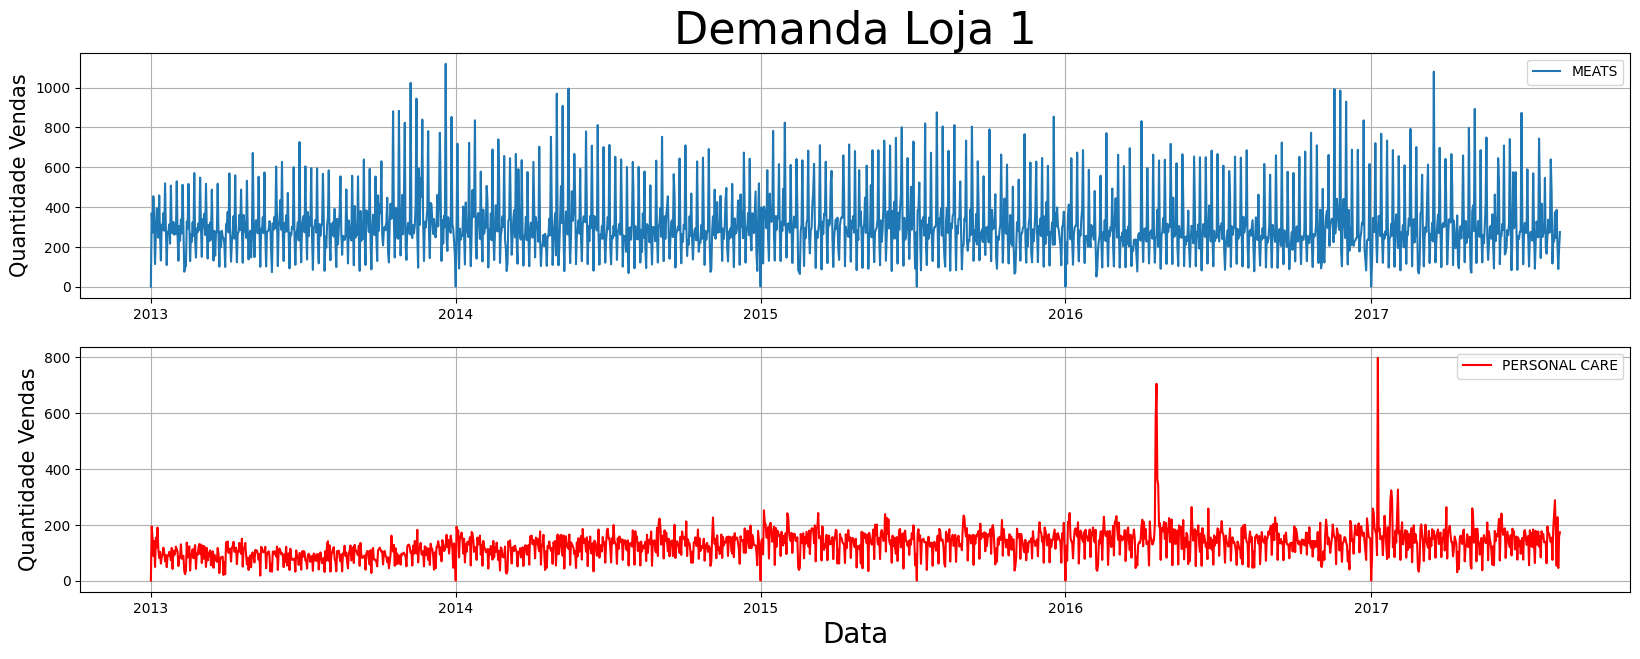

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (20, 7))

df=data2.loc[(data['store_nbr'] == 1)]
df1=df[data2.family=='MEATS']
df2=df[data2.family=='PERSONAL CARE']

ax[0].set_title(f'Demanda Loja 1', fontsize=32)
#ax[0].set_ylabel('Demanda por Vendas', fontsize=20)
#ax[0].set_xlabel('Data', fontsize=20)
ax[0].plot(df1.date,df1.sales,label='MEATS')
ax[0].legend()
ax[0].set_ylabel('Quantidade Vendas', fontsize=15)
ax[0].grid()
#ax[0].set_xlabel('Data', fontsize=20)
ax[1].plot(df2.date,df2.sales,color='red',label='PERSONAL CARE')
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Data', fontsize=20)
ax[1].set_ylabel('Quantidade Vendas', fontsize=15)

plt.show()

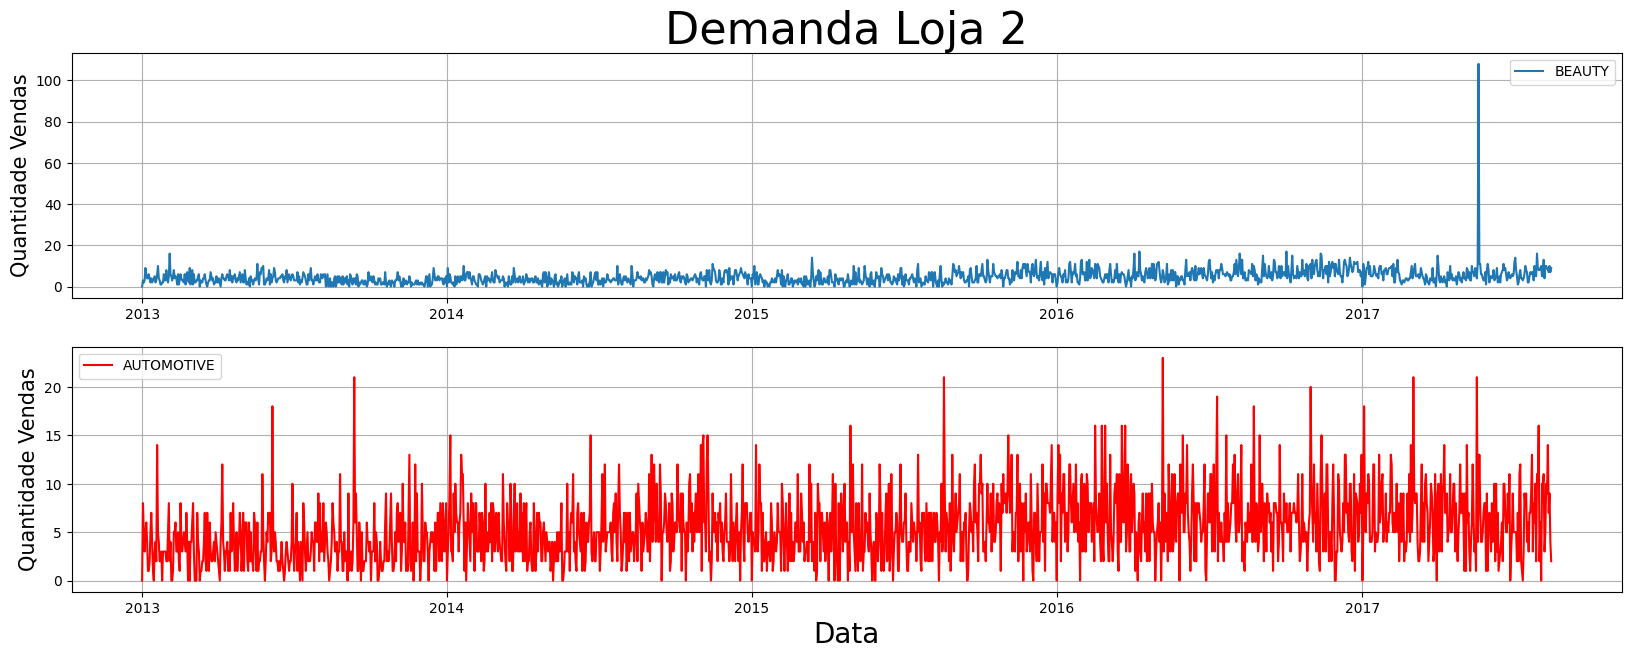

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (20, 7))

df=data2.loc[(data['store_nbr'] == 2)]
df1=df[data2.family=='BEAUTY']
df2=df[data2.family=='AUTOMOTIVE']

ax[0].set_title(f'Demanda Loja 2', fontsize=32)
#ax[0].set_ylabel('Demanda por Vendas', fontsize=20)
#ax[0].set_xlabel('Data', fontsize=20)
ax[0].plot(df1.date,df1.sales,label='BEAUTY')
ax[0].legend()
ax[0].set_ylabel('Quantidade Vendas', fontsize=15)
ax[0].grid()
#ax[0].set_xlabel('Data', fontsize=20)
ax[1].plot(df2.date,df2.sales,color='red',label='AUTOMOTIVE')
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Data', fontsize=20)
ax[1].set_ylabel('Quantidade Vendas', fontsize=15)

plt.show()

## Verifica os Valores Unicos e Nulos

In [670]:
print(data2.date.value_counts().sum())
print(data2.date.isna().sum())

6736
0


In [671]:
print(data2.store_nbr.value_counts().sum())
print(data2.store_nbr.isna().sum())

6736
0


In [598]:
print(data2.family.value_counts().sum())
print(data2.family.isna().sum())

6736
0


In [ ]:
print(data2.sales.value_counts().sum())
print(data2.sales.isna().sum())

6736
0


In [ ]:
print(data2.onpromotion.value_counts().sum())
print(data2.onpromotion.isna().sum())

6736
0


## Pré-Processamento

## Separa em Treino e Validação

In [672]:
cut_date='2017-05-01'
train = data2.loc[data2['date'] < cut_date]
valid = data2.loc[(data2['date'] >= cut_date)]
h = valid['date'].nunique()

In [673]:
len(data2)

6736

In [674]:
len(train)

6308

In [675]:
len(valid)

428

In [676]:
h

107

# Renomeia Colunas

In [677]:
train.store_nbr=train.store_nbr.astype(str)
valid.store_nbr=valid.store_nbr.astype(str)

In [678]:
train.family=train.store_nbr+'#'+train.family
valid.family=valid.store_nbr+'#'+valid.family

In [679]:
train.drop('store_nbr',axis=1,inplace=True)
valid.drop('store_nbr',axis=1,inplace=True)

In [680]:
train = train.rename(columns={'date': 'ds', 'sales': 'y', 'family': 'unique_id'})
valid = valid.rename(columns={'date': 'ds', 'sales': 'y', 'family': 'unique_id'})

In [681]:
p=len(valid)/len(train)*100
print('percentual de validação {}%'.format(round(p,2)))

percentual de validação 6.79%


## Feature Engeeniering - Adiciona Variáveis Extras

In [682]:
train=add_time_features(train)

In [683]:
valid=add_time_features(valid)

In [684]:
train.month.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [685]:
train.day_of_month.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [686]:
#train.query("week_of_year==0")

In [687]:
train, valid = add_target_encoding_features(train,valid,['unique_id','month', 'day_of_month'],target='y')

In [688]:
train.isna().sum()

ds               0
unique_id        0
y                0
onpromotion      0
year             0
quarter          0
month            0
day_of_month     0
day_of_year      0
day_of_week      0
week_of_month    0
week_of_year     0
is_weekeend_0    0
is_weekeend_1    0
std_per_y        4
median_per_y     0
mean_per_y       0
dtype: int64

In [689]:
valid.isna().sum()

ds               0
unique_id        0
y                0
onpromotion      0
year             0
quarter          0
month            0
day_of_month     0
day_of_year      0
day_of_week      0
week_of_month    0
week_of_year     0
is_weekeend_0    0
is_weekeend_1    0
std_per_y        0
median_per_y     0
mean_per_y       0
dtype: int64

In [690]:
train=fill_na(train)
valid=fill_na(valid)
#train.fillna(0,inplace=True)
#valid.fillna(0,inplace=True)

In [691]:
train.isna().sum()

ds               0
unique_id        0
y                0
onpromotion      0
year             0
quarter          0
month            0
day_of_month     0
day_of_year      0
day_of_week      0
week_of_month    0
week_of_year     0
is_weekeend_0    0
is_weekeend_1    0
std_per_y        0
median_per_y     0
mean_per_y       0
dtype: int64

In [692]:
valid.isna().sum()

ds               0
unique_id        0
y                0
onpromotion      0
year             0
quarter          0
month            0
day_of_month     0
day_of_year      0
day_of_week      0
week_of_month    0
week_of_year     0
is_weekeend_0    0
is_weekeend_1    0
std_per_y        0
median_per_y     0
mean_per_y       0
dtype: int64

In [693]:
train=train.sort_values(['unique_id','ds']).reset_index()
valid=valid.sort_values(['unique_id','ds']).reset_index()
train.drop('index',axis=1,inplace=True)
valid.drop('index',axis=1,inplace=True)

In [694]:
train

,ds,unique_id,y,onpromotion,year,quarter,month,day_of_month,day_of_year,day_of_week,week_of_month,week_of_year,is_weekeend_0,is_weekeend_1,std_per_y,median_per_y,mean_per_y
0,2013-01-01,1#MEATS,0.000,0,0,0,0,0,0,1,0,0,1,0,0.000000,0.000,0.000000
1,2013-01-02,1#MEATS,369.101,0,0,0,0,1,1,2,0,0,1,0,114.291342,298.455,281.169000
2,2013-01-03,1#MEATS,272.319,0,0,0,0,2,2,3,0,0,1,0,237.474399,272.319,324.158340
3,2013-01-04,1#MEATS,454.172,0,0,0,0,3,3,4,0,0,1,0,123.683895,326.203,310.230004
4,2013-01-05,1#MEATS,328.940,0,0,0,0,4,4,5,0,0,0,1,130.710053,328.940,301.661400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,2017-04-26,2#BEAUTY,7.000,0,4,1,3,25,115,2,3,16,1,0,2.880972,6.000,6.600000
6304,2017-04-27,2#BEAUTY,6.000,0,4,1,3,26,116,3,3,16,1,0,1.923538,6.000,5.800000
6305,2017-04-28,2#BEAUTY,3.000,0,4,1,3,27,117,4,3,16,1,0,2.549510,3.000,3.000000
6306,2017-04-29,2#BEAUTY,4.000,0,4,1,3,28,118,5,4,16,0,1,2.387467,4.000,3.800000


In [695]:
valid

,ds,unique_id,y,onpromotion,year,quarter,month,day_of_month,day_of_year,day_of_week,week_of_month,week_of_year,is_weekeend_0,is_weekeend_1,std_per_y,median_per_y,mean_per_y
0,2017-05-01,1#MEATS,70.039,0,0,1,4,0,120,0,0,17,1,0,120.967761,151.5435,198.837500
1,2017-05-02,1#MEATS,378.861,0,0,1,4,1,121,1,0,17,1,0,350.265065,283.7170,446.562865
2,2017-05-03,1#MEATS,408.748,0,0,1,4,2,122,2,0,17,1,0,243.200461,280.2880,331.590000
3,2017-05-04,1#MEATS,279.700,1,0,1,4,3,123,3,0,17,1,0,107.485664,300.9870,264.321995
4,2017-05-05,1#MEATS,893.130,49,0,1,4,4,124,4,0,17,1,0,80.551604,247.6000,239.435000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,2017-08-11,2#BEAUTY,8.000,1,0,2,7,10,222,4,1,31,1,0,2.828427,5.0000,4.000000
424,2017-08-12,2#BEAUTY,7.000,1,0,2,7,11,223,5,1,31,0,1,2.061553,1.5000,1.750000
425,2017-08-13,2#BEAUTY,10.000,1,0,2,7,12,224,6,1,31,0,1,3.095696,2.0000,2.750000
426,2017-08-14,2#BEAUTY,7.000,1,0,2,7,13,225,0,1,32,1,0,1.414214,3.5000,4.000000


In [696]:
train.median_per_y.mean()

106.3668293246671

In [697]:
train.mean_per_y.mean()

112.83967868753963

In [698]:
train.std_per_y.mean()

51.321259242203965

In [699]:
valid.median_per_y.mean()

106.21320559579439

In [700]:
valid.mean_per_y.mean()

112.0727518078271

In [701]:
valid.std_per_y.mean()

51.47305909425314

In [630]:
#train.query("unique_id=='1#MEATS'")

In [702]:
columns=train.columns[~train.columns.isin(['ds', 'unique_id', 'y'])]
columns

Index(['onpromotion', 'year', 'quarter', 'month', 'day_of_month',
       'day_of_year', 'day_of_week', 'week_of_month', 'week_of_year',
       'is_weekeend_0', 'is_weekeend_1', 'std_per_y', 'median_per_y',
       'mean_per_y'],
      dtype='object')

In [703]:
type(columns)

pandas.core.indexes.base.Index

In [704]:
cols_scale=['y']+columns.tolist()
cols_scale=pd.core.indexes.base.Index(cols_scale)

In [705]:
train[cols_scale]=train[cols_scale].astype(float)
valid[cols_scale]=valid[cols_scale].astype(float)

In [706]:
scaler, train_scaled = scale(train,cols_scale)

## Treina o Modelo

In [772]:
models = [NBEATS(futr_exog_list=columns,h=h,input_size=5*h,max_steps=100,loss=WMAPE(),scaler_type=None)]
model = NeuralForecast(models=models, freq='D')
#input_size=5*h

Seed set to 1


In [773]:
#load model
#model = NeuralForecast.load(path='saved_models/')

In [774]:
type(model)

neuralforecast.core.NeuralForecast

In [775]:
train.shape

(6308, 17)

In [776]:
model.fit(df=train_scaled)

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

In [786]:
#save model
model.save(path='saved_models/',
        model_index=None,
        overwrite=True,
        save_dataset=True)

## Realiza o Forecast nos Dados de Validação

In [796]:
#Apaga os valores corretos dos dados de validação antes de passar para o modelo
#valid_.merge(train[['ds','unique_id', 'y']],on=['ds', 'unique_id'], how='left')
#pred = model.predict(futr_df=valid_).reset_index()
pred = model.predict().reset_index()
pred = pred.merge(valid[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='inner')
pred = invert_scale(scaler, pred, ['NBEATS'])
pred

Predicting: |                                                                                    | 0/? [00:00<…

,unique_id,ds,NBEATS,y
0,1#MEATS,2017-05-01,275.675454,70.039
1,1#MEATS,2017-05-02,266.418547,378.861
2,1#MEATS,2017-05-03,299.561638,408.748
3,1#MEATS,2017-05-04,253.476375,279.700
4,1#MEATS,2017-05-05,676.804537,893.130
...,...,...,...,...
423,2#BEAUTY,2017-08-11,1.080689,8.000
424,2#BEAUTY,2017-08-12,3.084362,7.000
425,2#BEAUTY,2017-08-13,1.912515,10.000
426,2#BEAUTY,2017-08-14,1.947107,7.000


In [797]:
len(pred)

428

In [798]:
cond1=pred.unique_id.apply(lambda x:x.split("#")[0]=='1')
cond2=pred.unique_id.apply(lambda x:x.split("#")[0]=='2')

loja1=pred[cond1]
loja2=pred[cond2]

## Compara os Resultados das Previsões e os Reais

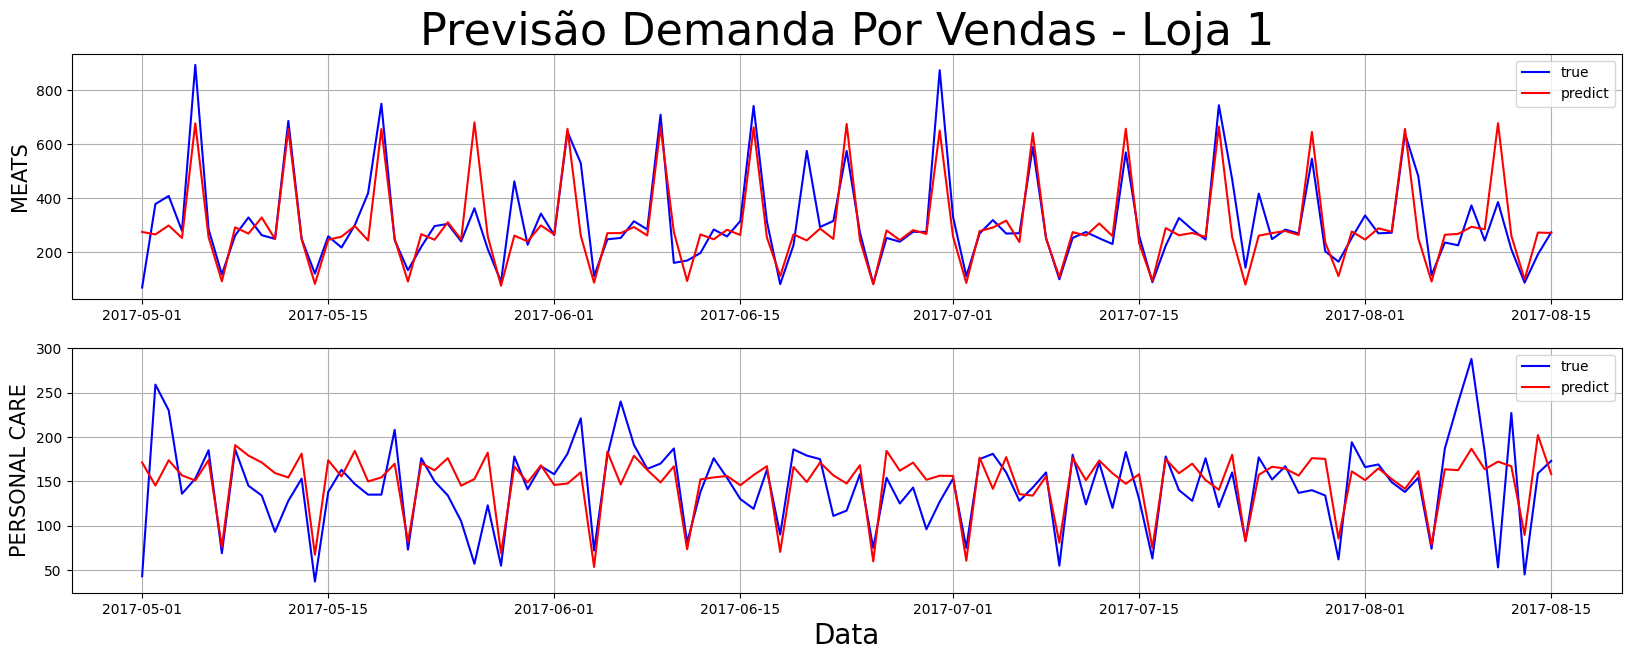

In [799]:
fig, ax = plt.subplots(2, 1, figsize = (20, 7))

condA=loja1.unique_id.apply(lambda x:x.split("#")[1]=='MEATS')
condB=loja1.unique_id.apply(lambda x:x.split("#")[1]=='PERSONAL CARE')

dfA=loja1[condA]
dfB=loja1[condB]

ax[0].set_title(f'Previsão Demanda Por Vendas - Loja 1', fontsize=32)
#ax[0].set_ylabel('Demanda por Vendas', fontsize=20)
#ax[0].set_xlabel('Data', fontsize=20)
ax[0].plot(dfA.ds,dfA.y,color='blue',label='true')
ax[0].plot(dfA.ds,dfA.NBEATS,color='red',label='predict')
ax[0].legend()
ax[0].set_ylabel('MEATS', fontsize=15)
ax[0].grid()
#ax[0].set_xlabel('Data', fontsize=20)
ax[1].plot(dfB.ds,dfB.y,color='blue',label='true')
ax[1].plot(dfB.ds,dfB.NBEATS,color='red',label='predict')
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Data', fontsize=20)
ax[1].set_ylabel('PERSONAL CARE', fontsize=15)

plt.show()

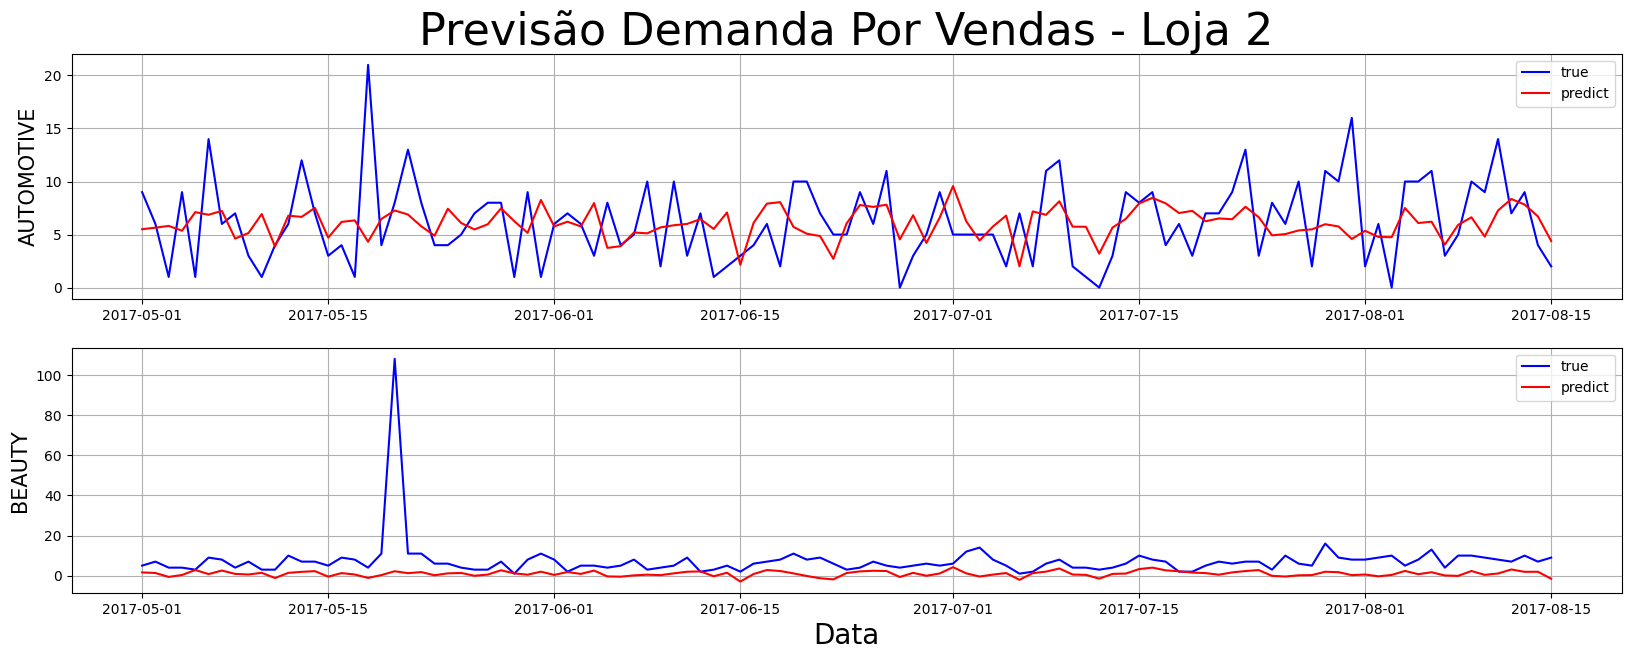

In [800]:
fig, ax = plt.subplots(2, 1, figsize = (20, 7))

condA=loja2.unique_id.apply(lambda x:x.split("#")[1]=='AUTOMOTIVE')
condB=loja2.unique_id.apply(lambda x:x.split("#")[1]=='BEAUTY')

dfA=loja2[condA]
dfB=loja2[condB]

ax[0].set_title(f'Previsão Demanda Por Vendas - Loja 2', fontsize=32)
#ax[0].set_ylabel('Demanda por Vendas', fontsize=20)
#ax[0].set_xlabel('Data', fontsize=20)
ax[0].plot(dfA.ds,dfA.y,color='blue',label='true')
ax[0].plot(dfA.ds,dfA.NBEATS,color='red',label='predict')
ax[0].legend()
ax[0].set_ylabel('AUTOMOTIVE', fontsize=15)
ax[0].grid()
#ax[0].set_xlabel('Data', fontsize=20)
ax[1].plot(dfB.ds,dfB.y,color='blue',label='true')
ax[1].plot(dfB.ds,dfB.NBEATS,color='red',label='predict')
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Data', fontsize=20)
ax[1].set_ylabel('BEAUTY', fontsize=15)

plt.show()

# Resultados:

## Gerais

In [801]:
y_pred=pred['NBEATS'].values
y_true=pred['y'].values
wmape = mean_absolute_percentage_error(y_true, y_pred, sample_weight=y_true)
#print("WMAPE: {:.2f}%".format(wmape*100))
pred_wmape=wmape_(y_true, y_pred)
pred_mape=mape(y_true, y_pred)
pred_rmse=rmse_(y_true, y_pred)
pred_r2=r2_score(y_true, y_pred)
pred_rmsle=rmsle(y_true, y_pred)
print("Resultados Gerais:")
print('RMSE=',pred_rmse)
print('MAPE=',pred_mape)
print('WMAPE=',pred_wmape)
print('r2_score=',pred_r2)
print('pred_rmsle=',pred_rmsle)
print()

Resultados Gerais:
RMSE= 50.085595264171964
MAPE= inf
WMAPE= 0.2026990711640427
r2_score= 0.8944544463210863
pred_rmsle= nan



## Loja 1

In [802]:
y_pred=loja1['NBEATS'].values
y_true=loja1['y'].values
wmape = mean_absolute_percentage_error(y_true, y_pred, sample_weight=y_true)
#print("WMAPE: {:.2f}%".format(wmape*100))
pred_wmape=wmape_(y_true, y_pred)
pred_mape=mape(y_true, y_pred)
pred_rmse=rmse_(y_true, y_pred)
pred_r2=r2_score(y_true, y_pred)
pred_rmsle=rmsle(y_true, y_pred)
print("Loja 1:")
print('RMSE=',pred_rmse)
print('MAPE=',pred_mape)
print('WMAPE=',pred_wmape)
print('r2_score=',pred_r2)
print('pred_rmsle=',pred_rmsle)
print()

Loja 1:
RMSE= 70.27148154076463
MAPE= 0.2231744357040989
WMAPE= 0.18797587623234713
r2_score= 0.7840729717687808
pred_rmsle= 0.29200681417709945



## Loja 2

In [803]:
y_pred=loja2['NBEATS'].values
y_true=loja2['y'].values
wmape = mean_absolute_percentage_error(y_true, y_pred, sample_weight=y_true)
#print("WMAPE: {:.2f}%".format(wmape*100))
pred_wmape=wmape_(y_true, y_pred)
pred_mape=mape(y_true, y_pred)
pred_rmse=rmse_(y_true, y_pred)
pred_r2=r2_score(y_true, y_pred)
pred_rmsle=rmsle(y_true, y_pred)
print("Loja 2:")
print('RMSE=',pred_rmse)
print('MAPE=',pred_mape)
print('WMAPE=',pred_wmape)
print('r2_score=',pred_r2)
print('pred_rmsle=',pred_rmsle)
print()

Loja 2:
RMSE= 8.891152231227853
MAPE= inf
WMAPE= 0.6974792771365741
r2_score= -0.32396114743646276
pred_rmsle= nan

